In [1]:
from demo import np_to_torch, pred, scale_input
from dataloader import read_image, read_trimap
from networks.models import build_model
import torch
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def trimap(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake

Using cache found in C:\Users\Saad.LAKES/.cache\torch\hub\pytorch_vision_v0.6.0


True

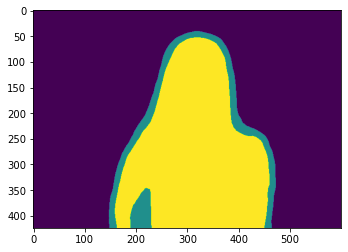

In [3]:
CLASS_MAP = {"background": 0, "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, "bus": 6, "car": 7,
             "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
             "potted plant": 16, "sheep": 17, "sofa": 18, "train": 19, "tv/monitor": 20}

model_trimap = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model_trimap.eval()
input_image = cv2.imread('examples/images/image_girl.png')
original_image = input_image.copy()

input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model_trimap(input_batch)['out'][0]
    output = torch.softmax(output, 0)

output_cat = output[CLASS_MAP['person'], ...].numpy()

trimap_image = trimap(output_cat, 1, 0.85)

plt.imshow(trimap_image)
cv2.imwrite('examples/trimaps/image_girl1.png',trimap_image)

In [4]:
class Args:
  encoder = 'resnet50_GN_WS'
  decoder = 'fba_decoder'
  weights = 'FBA.pth'
args=Args()
try:
    model = build_model(args)
except:
    !gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
    model = build_model(args)

modifying input layer to accept 11 channels


In [5]:
image = read_image('examples/images/image_girl.png')
trimap = read_trimap('examples/trimaps/image_girl1.png')

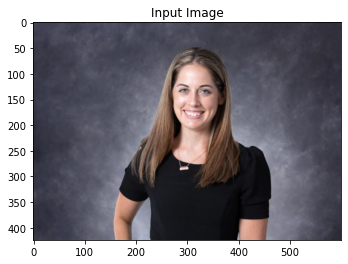

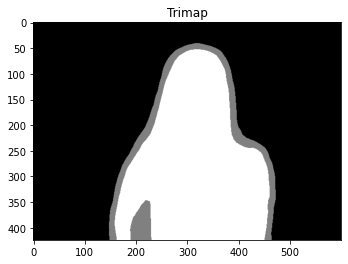

In [6]:
plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
trimap.shape

(424, 600, 2)

In [7]:
fg, bg, alpha = pred(image, trimap, model)

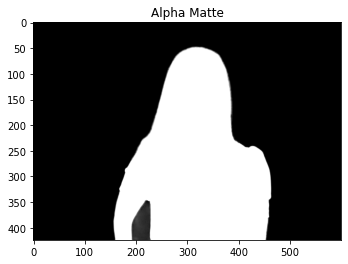

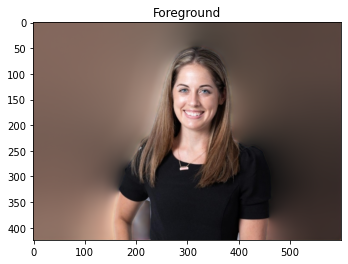

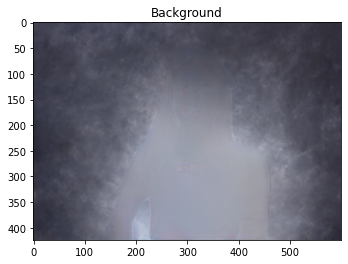

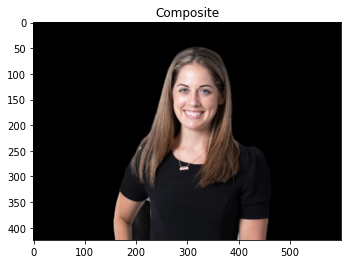

In [38]:
plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.title('Foreground')
plt.imshow(fg)
plt.show()
plt.title('Background')
plt.imshow(bg)
plt.show()
plt.title('Composite')
composite = fg*alpha[:,:,None]
plt.imshow(composite)
plt.show()

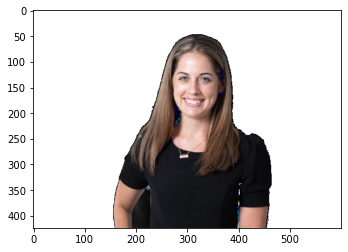

In [39]:
composite1 = composite.copy()
composite1[composite1==0]=1
plt.imshow(composite1)

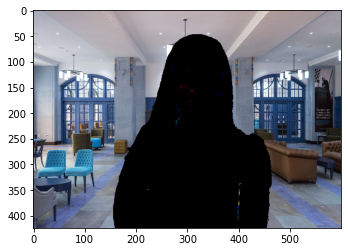

In [40]:
background = cv2.imread('backgrounds/background7.jpg')
background = cv2.resize(background,(composite.shape[1],composite.shape[0]))
background = background/255.
background[composite1!=1]=0
plt.imshow(background)
combined = cv2.add(background,composite1,dtype=cv2.CV_64F)

In [41]:
combined = (combined*255.).astype(np.uint8)

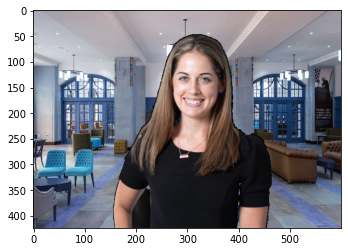

In [42]:
plt.imshow(combined)

In [43]:
plt.imsave('Girl Image.jpg',combined)